In [103]:
import pymc as pm
import pytensor.tensor as pt
import pytensor.scan as scan
import numpy as np
import pandas as pd
from pymc_marketing.mmm.transformers import geometric_adstock
import matplotlib.pyplot as plt

In [104]:
# set a random speed for reproducibility
np.random.seed(86)

# Simulate Data

In [117]:
# read in simulated data
df_mini = pd.read_csv("./data/simulated_data_long_form.csv")
display(df_mini)

,date,channel,subchannel,spend,adstocked_spend,y
0,2024-01-01,Display,Publisher A,71.810382,71.810382,29.052051
1,2024-01-01,Display,Publisher B,44.833942,44.833942,29.052051
2,2024-01-01,Linear,Network X,41.468508,41.468508,29.052051
3,2024-01-01,Linear,Network Y,41.469069,41.469069,29.052051
4,2024-01-01,Linear,Network Z,139.491432,139.491432,29.052051
...,...,...,...,...,...,...
445,2024-03-30,Display,Publisher A,78.096653,107.437781,108.366021
446,2024-03-30,Display,Publisher B,66.217804,86.456810,108.366021
447,2024-03-30,Linear,Network X,77.571951,295.764330,108.366021
448,2024-03-30,Linear,Network Y,89.751053,265.817608,108.366021


## Store Channel to Subchannel Mapping

In [118]:
# Group subchannels by channel and sort everything
channel_groups = (
    df_mini[["channel", "subchannel"]]
    .drop_duplicates()
    .sort_values(["channel", "subchannel"])
)

# Extract the sorted list of channels and subchannels
channels = sorted(channel_groups["channel"].unique().tolist())
subchannels = channel_groups["subchannel"].tolist()  # Already sorted within each channel

# Create index mappings
channel_to_idx = {ch: i for i, ch in enumerate(channels)}
subchannel_to_idx = {sub: i for i, sub in enumerate(subchannels)}

# Add integer index columns to df
df_mini["channel_idx"] = df_mini["channel"].map(channel_to_idx).astype(int)
df_mini["subchannel_idx"] = df_mini["subchannel"].map(subchannel_to_idx).astype(int)

# Create mapping from subchannel to parent channel index
subchannel_to_channel_idx = {
    sub: channel_to_idx[df_mini.loc[df_mini["subchannel"] == sub, "channel"].iloc[0]]
    for sub in subchannels
}

# List of channel indices for each subchannel, in subchannels order
channel_idx_for_each_subchannel = [subchannel_to_channel_idx[sub] for sub in subchannels]

# Group spend and row indices by subchannel in correct order
x_by_subchannel = []
obs_idx_by_subchannel = []

for sub in subchannels:
    sub_df = df_mini[df_mini["subchannel"] == sub]
    x_by_subchannel.append(sub_df["spend"].values)
    obs_idx_by_subchannel.append(sub_df.index.values)

print("Channels (sorted):", channels)
print("Subchannels (sorted by channel then subchannel):", subchannels)
print("channel_idx_for_each_subchannel:", channel_idx_for_each_subchannel)


Channels (sorted): ['Display', 'Linear']
Subchannels (sorted by channel then subchannel): ['Publisher A', 'Publisher B', 'Network X', 'Network Y', 'Network Z']
channel_idx_for_each_subchannel: [0, 0, 1, 1, 1]


## Plot Adstock vs. Spend

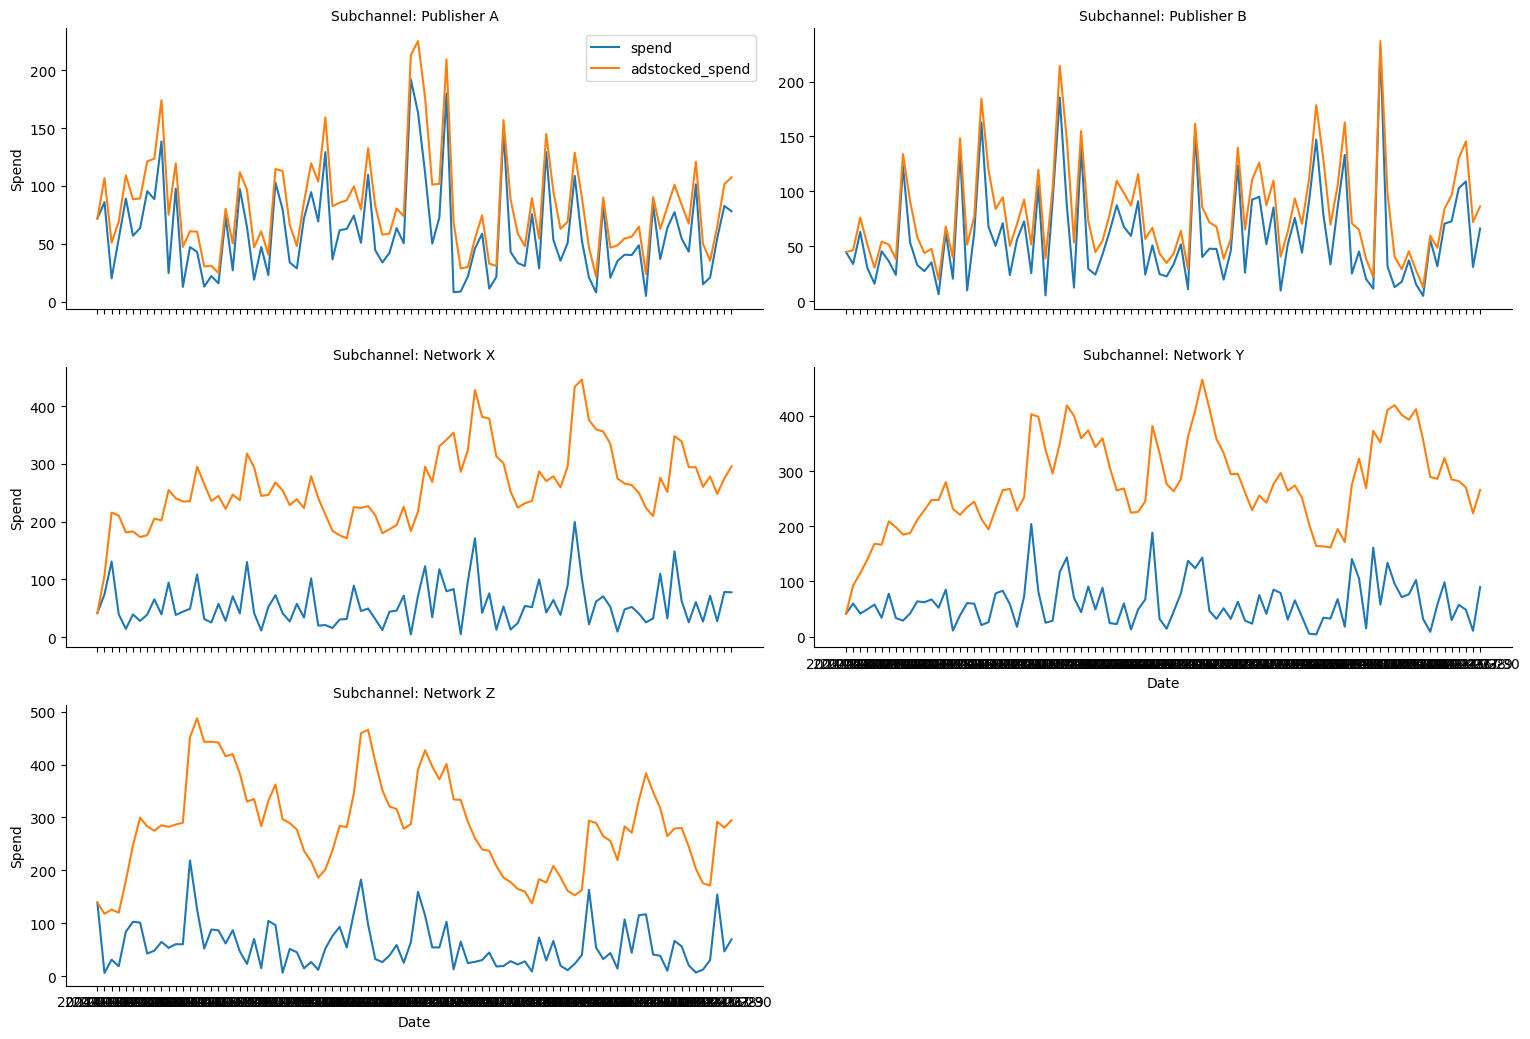

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Melt for long-form plotting with hue
df_plot = pd.melt(
    df_mini,
    id_vars=["date", "subchannel"],
    value_vars=["spend", "adstocked_spend"],
    var_name="type",
    value_name="value"
)

# Increase figure width for a wider chart
g = sns.FacetGrid(df_plot, col="subchannel", col_wrap=2, height=3.5, aspect=2.2, sharex=True, sharey=False)
g.map_dataframe(sns.lineplot, x="date", y="value", hue="type")

g.set_axis_labels("Date", "Spend")
g.set_titles("Subchannel: {col_name}")

# Only add one legend (not on every facet)
for ax in g.axes.flatten():
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, loc="best")
        break

g.tight_layout()
plt.show()

# Pivot to Wide Form

In [120]:
# Step 1: Ensure subchannel names are safe for column headers
df_mini["subchannel"] = df_mini["subchannel"].str.replace(" ", "_")

# Step 2: Pivot adstocked spend: rows = date, columns = subchannel
X = df_mini.pivot(index="date", columns="subchannel", values="spend").fillna(0)

# Step 3: Build subchannel → channel mapping (must match sanitized subchannel names)
subchannel_to_channel = (
    df_mini.drop_duplicates(subset=["subchannel", "channel"])
           .set_index("subchannel")["channel"]
           .to_dict()
)

# Step 4: Sort columns by channel → subchannel
X = X[[col for col in sorted(X.columns, key=lambda x: (subchannel_to_channel[x], x))]]

# Step 5: Extract 1 y-value per day (they're repeated across subchannels)
y = df_mini.groupby("date")["y"].first().sort_index()

# Optional: extract subchannel and channel indices
subchannel_idx = df_mini["subchannel_idx"].values
channel_idx = df_mini["channel_idx"].values

# Display to verify
display(X.head())
display(y.head())


subchannel,Publisher_A,Publisher_B,Network_X,Network_Y,Network_Z
date,,,,,
2024-01-01,71.810382,44.833942,41.468508,41.469069,139.491432
2024-01-02,86.001187,33.932340,74.094434,59.968808,6.477448
2024-01-03,20.137268,63.184969,130.955306,41.755566,31.740823
2024-01-04,54.420226,30.158534,39.532241,49.479074,19.204119
2024-01-05,89.101803,16.055443,14.183803,58.018513,84.400614


date
2024-01-01    29.052051
2024-01-02    47.613860
2024-01-03    63.412941
2024-01-04    65.549716
2024-01-05    70.108026
Name: y, dtype: float64

# Run Model

In [121]:
X.columns

Index(['Publisher_A', 'Publisher_B', 'Network_X', 'Network_Y', 'Network_Z'], dtype='object', name='subchannel')

In [126]:
import pymc as pm
import pytensor.tensor as pt
import numpy as np

# Set up coords
coords = {
    "channel": channels,                          # e.g., ['Display', 'Linear']
    "subchannel": subchannels,                    # e.g., ['Publisher A', ..., 'Network Z']
    "day": X.index                         # pandas.DatetimeIndex
}

n_days, n_subchannels = X.shape

# Ensure your index mapping is a NumPy array
channel_idx_for_each_subchannel = np.array(channel_idx_for_each_subchannel)

# Convert input to tensor variables
spend_matrix = pt.as_tensor_variable(X.values.astype(float))
y_tensor = pt.as_tensor_variable(y.values.astype(float))

with pm.Model(coords=coords) as model:
    # Priors
    mu_adstock_alpha = pm.HalfNormal("mu_adstock_alpha", sigma=1, dims="channel")
    sigma_adstock_alpha = pm.HalfNormal("sigma_adstock_alpha", sigma=.2, dims="channel")

    alpha = pm.TruncatedNormal(
        "adstock_alpha",
        mu=mu_adstock_alpha[channel_idx_for_each_subchannel],
        sigma=sigma_adstock_alpha[channel_idx_for_each_subchannel],
        lower=0,
        upper=1.0,
        dims="subchannel"
    )

    # Subchannel-level betas
    beta = pm.TruncatedNormal("beta", mu=0.5, sigma=0.3, lower=0, upper=1, dims="subchannel")

    # Global intercept and sigma
    intercept = pm.Normal("intercept", mu=0, sigma=.5)
    sigma = pm.HalfNormal("sigma", sigma=.5)

    # Apply adstock to each subchannel's spend series
    l_max = 64
    adstocked_list = []
    for i in range(n_subchannels):
        adstocked_i = geometric_adstock(spend_matrix[:, i], alpha[i], l_max=l_max)
        adstocked_list.append(adstocked_i)

    adstocked = pt.stack(adstocked_list, axis=1)  # shape: (n_days, n_subchannels)

    # Linear predictor
    mu = intercept + pt.sum(adstocked * beta, axis=1)

    # Likelihood
    pm.Normal("obs", mu=mu, sigma=sigma, observed=y_tensor)

    # Sample
    trace = pm.sample(400, tune=400, target_accept=0.9, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_adstock_alpha, sigma_adstock_alpha, adstock_alpha, beta, intercept, sigma]


Output()

Sampling 4 chains for 400 tune and 400 draw iterations (1_600 + 1_600 draws total) took 11 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [123]:
import arviz as az # Output Results


# 1. Posterior Summary
print("Posterior Summary:")
summary = az.summary(trace, round_to=2).reset_index()
display(summary)

Posterior Summary:


,index,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,adstock_alpha[Publisher A],0.29,0.00,0.29,0.29,0.00,0.00,934.05,893.51,1.00
1,adstock_alpha[Publisher B],0.28,0.00,0.28,0.28,0.00,0.00,997.00,939.61,1.01
2,adstock_alpha[Network X],0.79,0.00,0.79,0.79,0.00,0.00,681.03,769.43,1.01
3,adstock_alpha[Network Y],0.79,0.00,0.79,0.79,0.00,0.00,855.34,1190.60,1.01
4,adstock_alpha[Network Z],0.80,0.00,0.80,0.80,0.00,0.00,731.34,830.27,1.00
5,beta[Publisher A],0.10,0.00,0.10,0.10,0.00,0.00,841.40,656.18,1.01
6,beta[Publisher B],0.07,0.00,0.07,0.07,0.00,0.00,1160.36,1210.83,1.00
7,beta[Network X],0.15,0.00,0.15,0.15,0.00,0.00,676.31,624.67,1.00
8,beta[Network Y],0.12,0.00,0.12,0.12,0.00,0.00,680.22,385.39,1.01
9,beta[Network Z],0.05,0.00,0.05,0.05,0.00,0.00,796.88,833.17,1.01


Plotting posterior distributions...


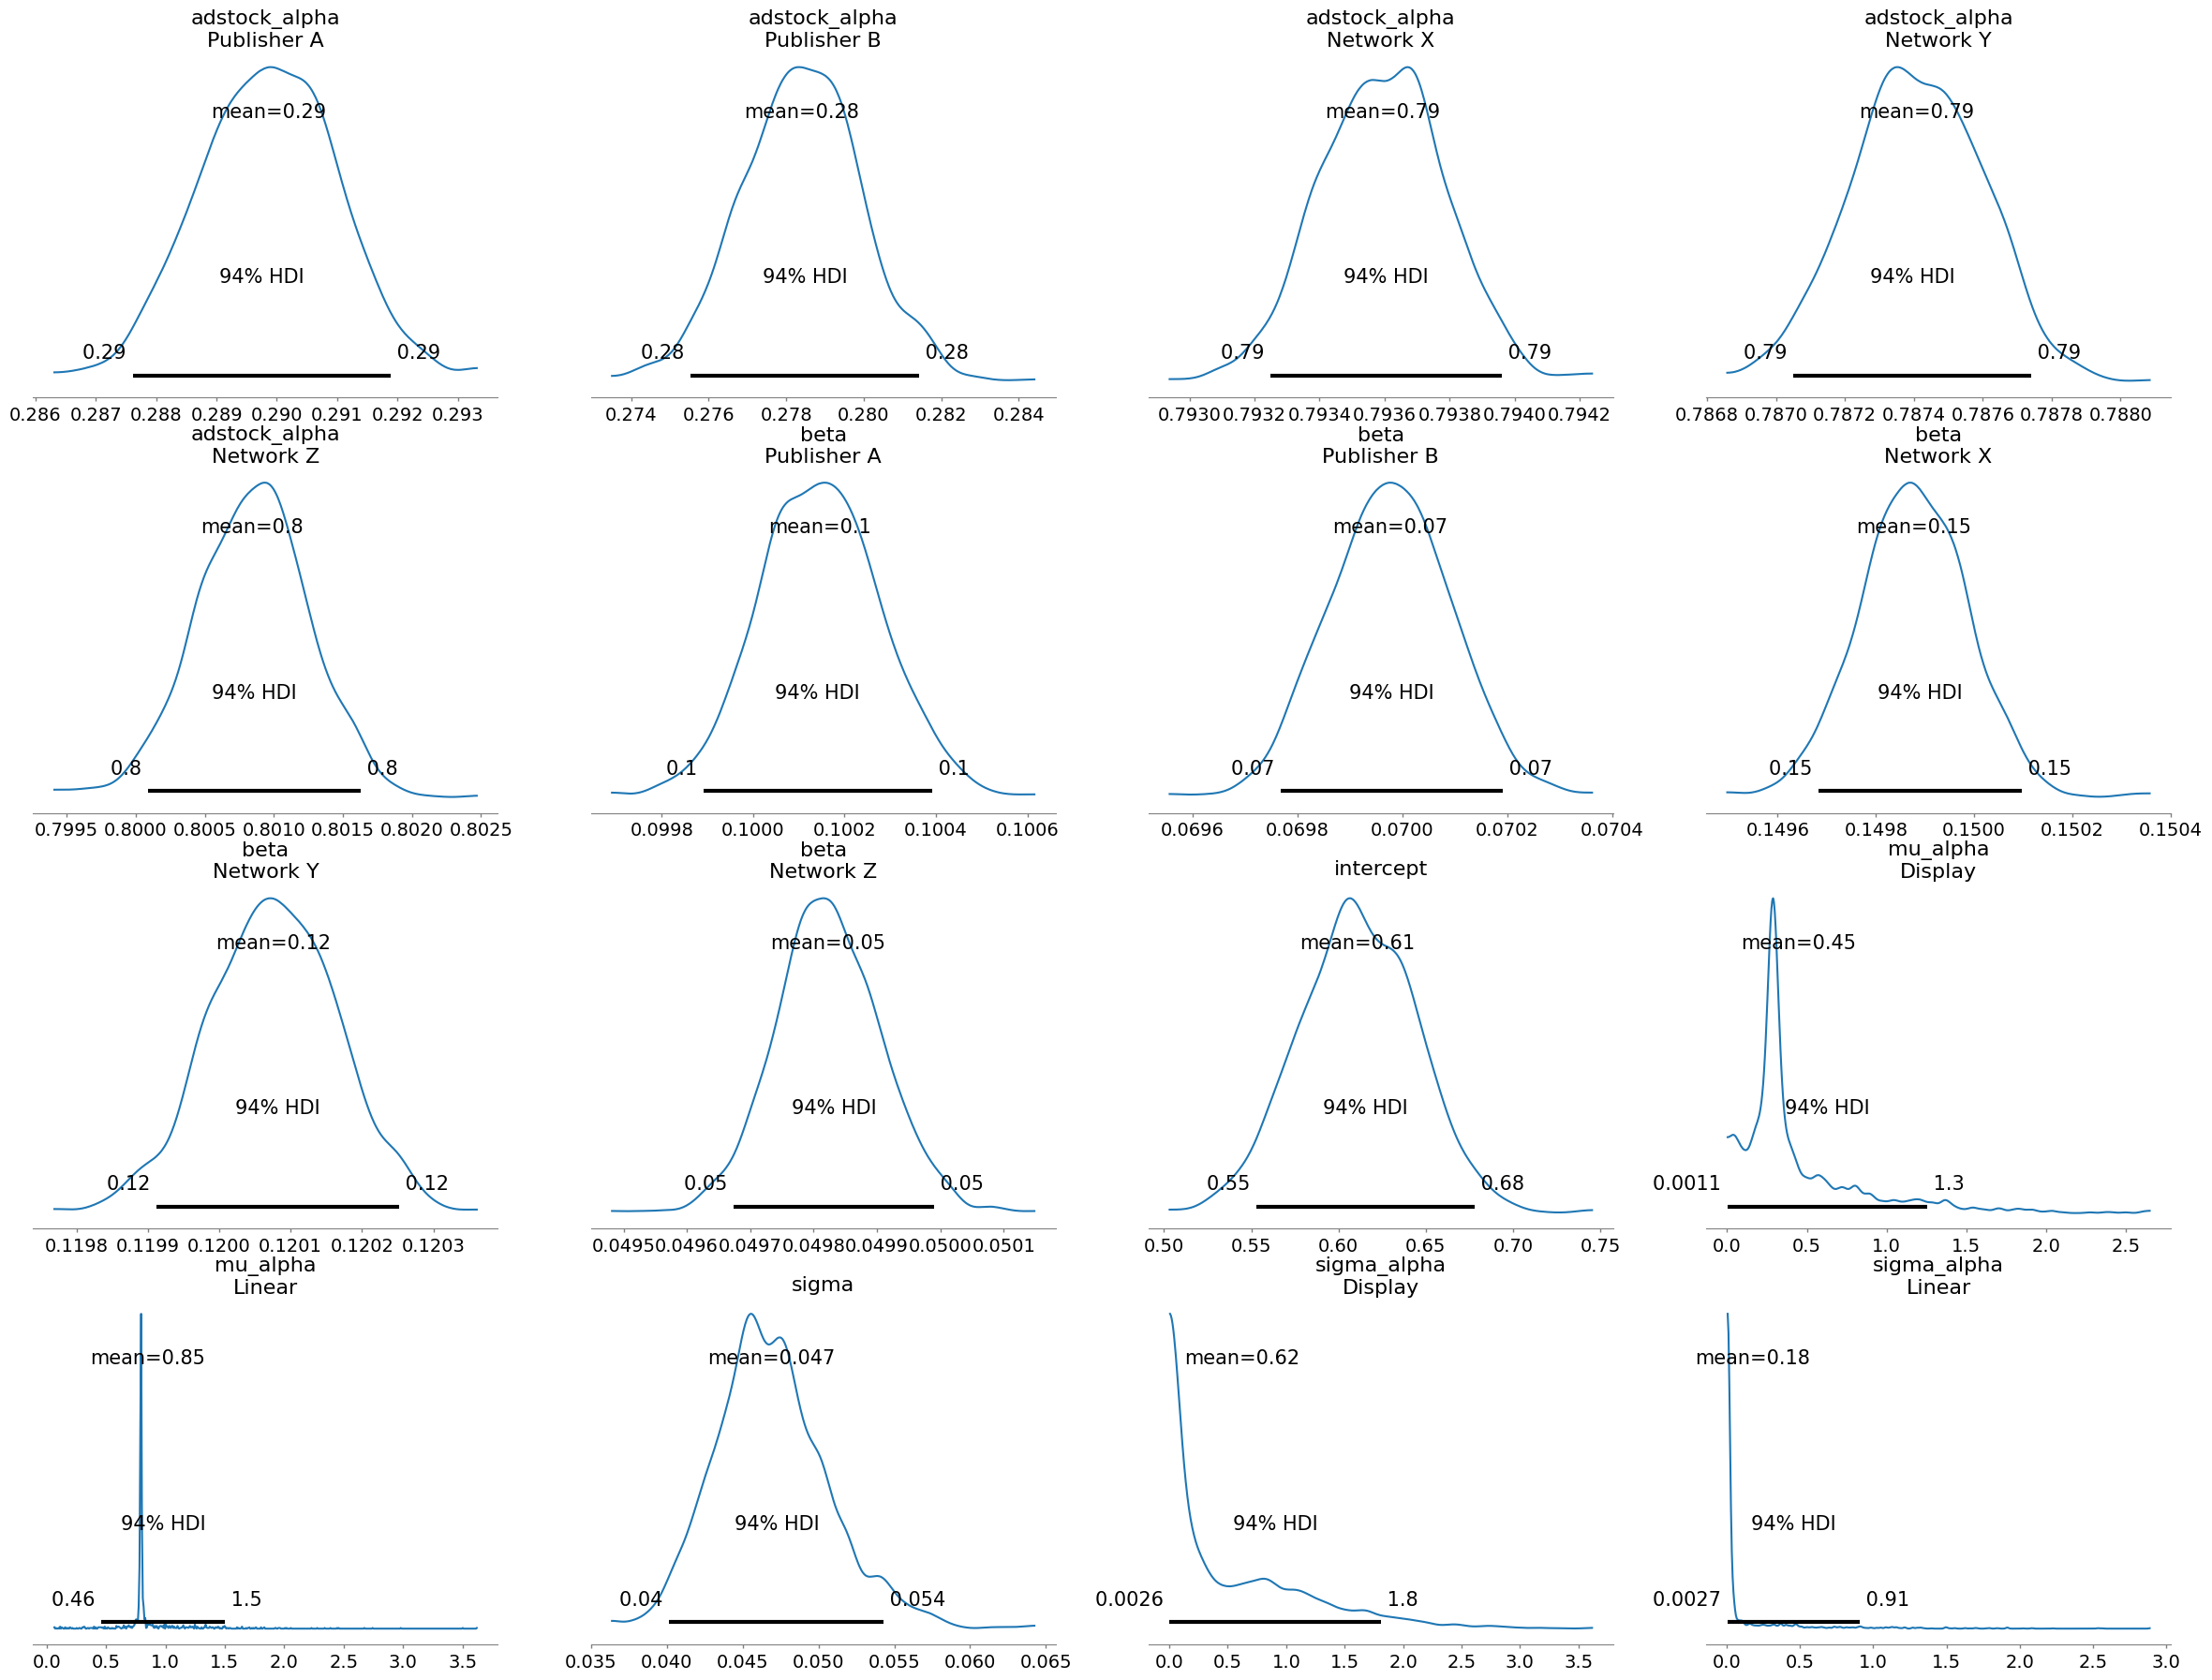

In [124]:


# Pass the dictionary to `var_names` to relabel the plots
print("Plotting posterior distributions...")
az.plot_posterior(trace)
plt.show()

Plotting trace plots...


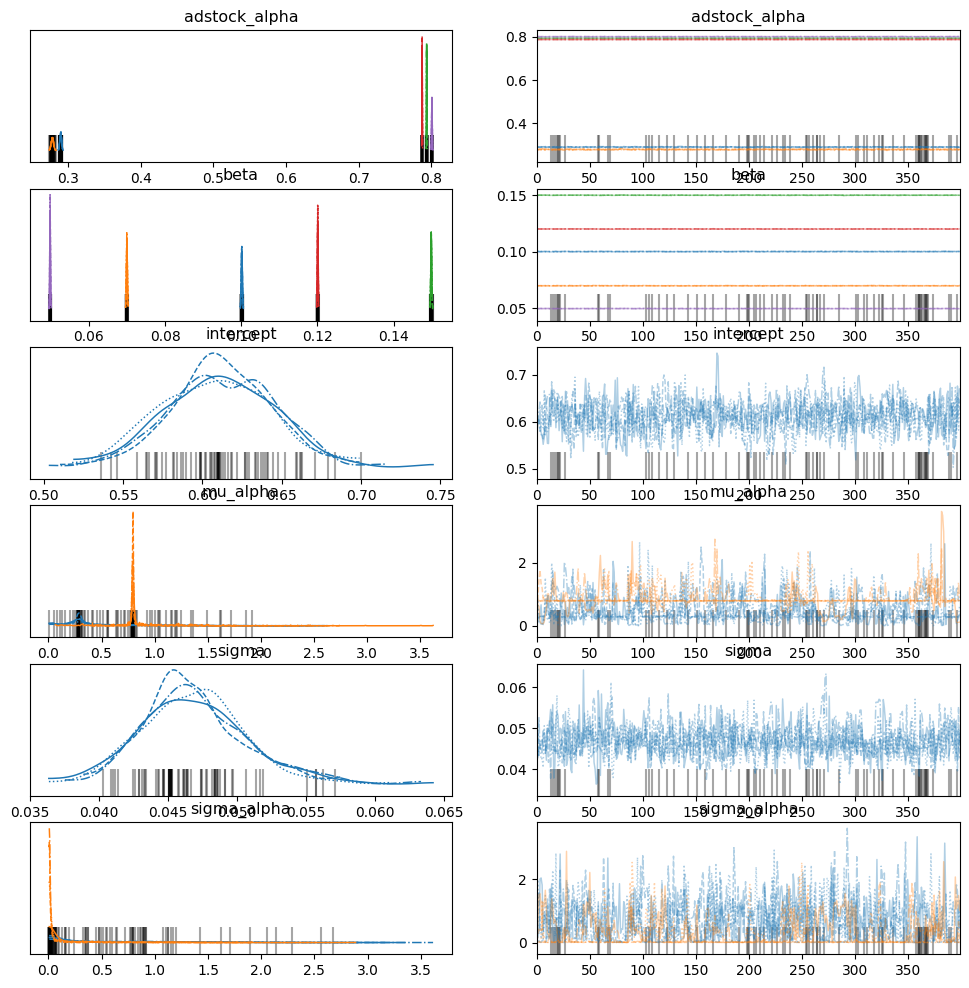

In [125]:
# 3. Trace Plots
print("Plotting trace plots...")
az.plot_trace(trace)
plt.show()

In [115]:
# Extract and Label Beta Coefficients
print("Beta Coefficients:")
beta_mean = trace.posterior["beta"].mean(dim=("chain", "draw"))
beta_std = trace.posterior["beta"].std(dim=("chain", "draw"))

# Map subchannel indices back to subchannel names
subchannel_mapping = {v: k for k, v in subchannel_to_idx.items()}

# Print labeled beta coefficients
for sub_idx, (mean, std) in enumerate(zip(beta_mean.values, beta_std.values)):
    subchannel_name = subchannel_mapping[sub_idx]
    print(f"Subchannel '{subchannel_name}': Mean = {mean:.3f}, Std = {std:.3f}")

# Save labeled beta coefficients to CSV
labeled_beta = pd.DataFrame({
    "Subchannel": [subchannel_mapping[i] for i in range(len(beta_mean))],
    "Beta_Mean": beta_mean.values,
    "Beta_Std": beta_std.values
})

display(labeled_beta)

Beta Coefficients:
Subchannel 'Publisher A': Mean = 0.727, Std = 0.018
Subchannel 'Publisher B': Mean = 0.450, Std = 0.018
Subchannel 'Network X': Mean = 0.743, Std = 0.011
Subchannel 'Network Y': Mean = 0.541, Std = 0.017
Subchannel 'Network Z': Mean = 0.306, Std = 0.014


,Subchannel,Beta_Mean,Beta_Std
0,Publisher A,0.726775,0.017870
1,Publisher B,0.449878,0.017967
2,Network X,0.742913,0.011392
3,Network Y,0.541358,0.017243
4,Network Z,0.305709,0.014146
